# FIT5221 Week 8 - Tutorial

**Objective of today’s lab**

For object detection, we can use FasterRCNN, SSD, YOLO, etc.

- FasterRCNN+InceptionResNet V2: high accuracy,
- ssd+mobilenet V2: small and fast.
- YOLO: high accuracy and fast.

[More examples of object detections using Tensorflow hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)

In [ ]:
pip install tensorflow-hub


In [6]:
## import libraries
from typing import List, Dict
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tensorflow.python.eager.context import PhysicalDevice

print("TensorFlow version:", tf.__version__)
# setting the growth GPU memory occupying and print devices
try:
    devices: List[PhysicalDevice] = tf.config.list_physical_devices('GPU')
    for device in devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("Use devices:", list(map(lambda d: d.name, devices)))
except IndexError:
    print("Use CPU")

TensorFlow version: 2.16.1
Use devices: []


In [8]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================


# Helper functions from https://www.tensorflow.org/hub/tutorials/object_detection

def display_image(image):
    # plt.figure(figsize=(20, 15))
    plt.figure(figsize=(15, 10))
    plt.grid(False)
    plt.axis("off")
    plt.imshow(image)


def download_and_rescale_image(url, scale=0.25,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image,
                             (int(pil_image.width * scale), int(pil_image.height * scale)),
                             Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes_bylabel(image, boxes, class_names, scores, class_ids, max_boxes=-1, min_score=0.1, labels=None):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    if (0, 0, 0) in colors:
        colors.remove((0, 0, 0))
    if labels is None:
      labels = class_ids
    print("Total detected boxes:", len(boxes))
    if max_boxes <= 0:
      max_boxes = len(boxes)
    for i in range(min(len(boxes), max_boxes)):
        if scores[i] >= min_score and class_ids[i] in labels:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

## Load pretraind model



In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import subprocess
import os

# Define the model name and URLs
model_name = "yolov5"

model_urls = {
    "faster_rcnn": "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1",
    "ssd": "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
}

# Function to run shell commands
def run_shell_command(command, cwd=None):
    result = subprocess.run(command, shell=True, cwd=cwd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running command: {command}")
        print(result.stderr)
    else:
        print(result.stdout)

# Check if the model is from TensorFlow Hub or yolov5
if model_name in model_urls.keys():
    model = hub.load(model_urls[model_name]).signatures["default"]
else:  # yolov5
    # Clone the yolov5 repository if it doesn't exist
    if not os.path.exists('yolov5'):
        run_shell_command('git clone https://github.com/ultralytics/yolov5')
    
    # Download the yolov5s.pt weights file if it doesn't exist
    if not os.path.exists('yolov5s.pt'):
        run_shell_command('gdown https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt')
    
    # Check if the exported model directory exists
    export_dir = 'yolov5/yolov5s_saved_model'
    if not os.path.exists(export_dir):
        # Convert the weight file to TensorFlow supported format
        run_shell_command('python export.py --weights ../yolov5s.pt --include saved_model', cwd='yolov5')
    
    # Load the converted model
    model = tf.saved_model.load(export_dir)

print("Model loaded successfully!")


Error running command: gdown https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
/bin/sh: gdown: command not found

Error running command: python export.py --weights ../yolov5s.pt --include saved_model
Traceback (most recent call last):
  File "/Users/jon/Documents/CNN_projects/assignment3/FIT5221_week8_tutorial 2/yolov5/export.py", line 59, in <module>
    import pandas as pd
ModuleNotFoundError: No module named 'pandas'



OSError: SavedModel file does not exist at: yolov5/yolov5s_saved_model/{saved_model.pbtxt|saved_model.pb}

## Use an image

Find any images online. Download and display it.

In [13]:
# TODO - select an image.

# Hint: There are many good images in Wikimedia Commons.
# https://commons.wikimedia.org/wiki/Main_Page
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Torbel_20190720_154901.jpg/2560px-Torbel_20190720_154901.jpg"
image_path = download_and_rescale_image(image_url, 0.5, True)

# Or you can choose an image on your local machine
# image_path = './yolov5/data/images/bus.jpg'

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

## Apply the model

In [ ]:
# TODO - Apply the model to the image

# Prepare the functions
def load_image(image_path: str):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img /= 255
    return img

def detect_object(model, img):
    # TODO - Reshape the image from [H, W, C] to [1, H, W, C]
    # Because the model takes a batch as input.
    if img.ndim == 3:
        img = img[tf.newaxis, ...]

    # TODO - Apply the model
    # It can be applied as `model(a_batch)`
    result = model(img)
    return result

# 80 classes of COCO dataset for parsing YOLOv5 results
COCO_CLASS_LABELS = ['person',
                     'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
                     'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                     'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                     'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                     'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                     'banana', 'apple', 'sandwich', 'orange', 'brocolli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
                     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
                     'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                     'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
                     'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

def parse_yolo_result(res, conf_thres=0.05):
    # For Yolov5, the return shape of `model(img)` is [res] with res has shape (1, 25200, 85)
    # There are 25200 anchor boxes, each associates with 85 values: x, y, w, h, obj_conf, class0, ..., class79

    # Get the result and convert shape (1, 25200, 85) -> (25200, 85)
    res = tf.squeeze(res[0])

    # Get bounding boxes, and convert from xywh -> xyxy format
    bb = res[..., 0:4]
    x,y,w,h = bb[..., 0], bb[..., 1], bb[..., 2], bb[..., 3]
    bboxes = tf.transpose(tf.convert_to_tensor([y - h/2, x - w/2, y + h/2, x + w/2]))

    # Get obj_conf
    obj_scores = tf.squeeze(res[..., 4:5])

    # Get class id for anchor boxes
    class_ids = tf.argsort(res[..., 5:], direction='DESCENDING')[:,0]

    # Get corresponding class labels
    class_labels = tf.convert_to_tensor([COCO_CLASS_LABELS[id] for id in class_ids])

    # Compute confidence score: conf = obj_conf * cls_conf
    class_scores = tf.math.reduce_max(res[..., 5:], axis=1) # maximum prob of bb
    conf_scores *= obj_scores

    # Filter by conf_thres
    idx = conf_scores > conf_thres

    # Gather result as a dictionary
    res_format = {
        "detection_boxes": bboxes[idx],
        "detection_class_entities": class_labels[idx],
        "detection_scores": conf_scores[idx],
        "detection_class_labels": class_ids[idx]
    }
    return res_format

<ipython-input-25-3b52e1230104>:66: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-25-3b52e1230104>:76: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


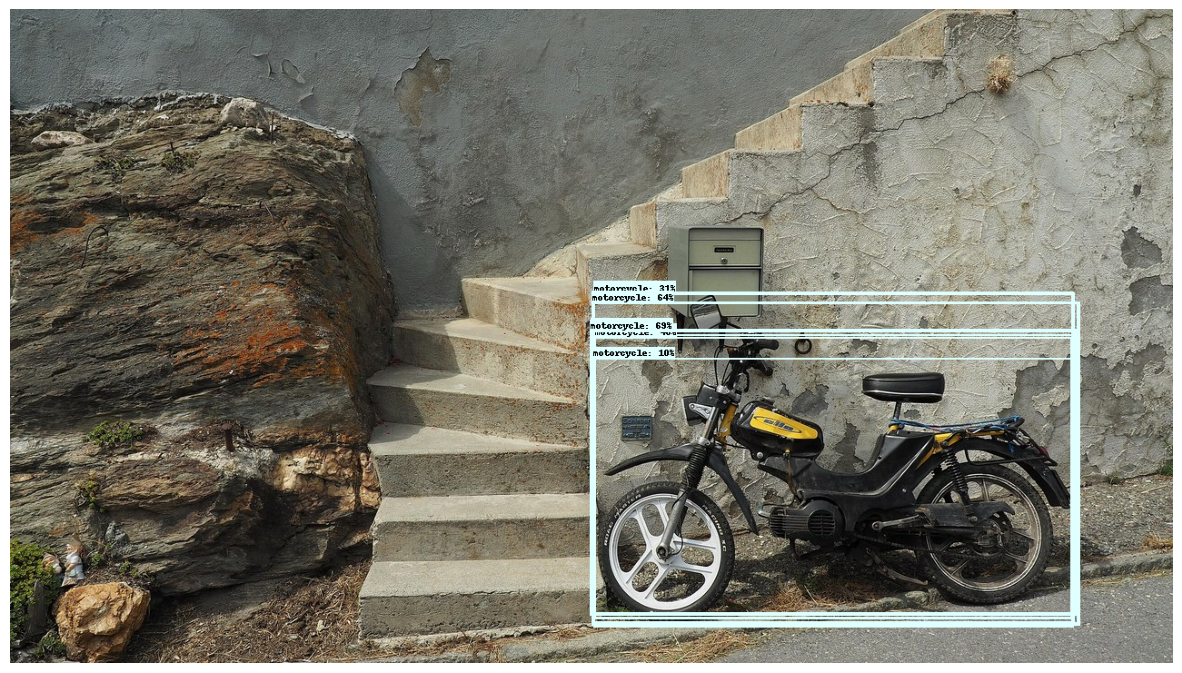

In [ ]:
img = load_image(image_path)

if model_name.startswith("yolo"):
    img_resized = tf.image.resize(img, size=(640, 640))
    result = detect_object(model, img_resized)
    result = parse_yolo_result(result)
else:
    result = detect_object(model, img)
plot = draw_boxes_bylabel(((img*255).numpy()).astype(np.uint8),
                  result["detection_boxes"].numpy(),
                  result["detection_class_entities"].numpy(),
                  result["detection_scores"].numpy(),
                  result["detection_class_labels"].numpy()
                  min_score=0.1)
display_image(plot)

In [ ]:
def get_iou(bb1, bb2):
  xmin1, ymin1, xmax1, ymax1 = bb1
  xmin2, ymin2, xmax2, ymax2 = bb2
  h_in = max(0, min(ymax1 - ymin2, ymax2 - ymin1))
  w_in = max(0, min(xmax1 - xmin2, xmax2 - xmin1))

  in_area = h_in * w_in

  bb1_area = (ymax1 - ymin1)*(xmax1-xmin1)
  bb2_area = (ymax2 - ymin2)*(xmax2-xmin2)

  iou = in_area / (bb1_area + bb2_area - in_area)
  return iou

def get_nms(bboxes, scores, threshold=0.7):
  idx_score = np.argsort(scores)[::-1]
  keep_idx = []
  while len(idx_score) > 0:
    idx_max = idx_score[0]
    # keep the bbox with highest confident score
    keep_idx.append(idx_max)
    bb_max = bboxes[idx_max]

    idx_score = np.delete(idx_score, 0, axis=0)

    idx_s_keep = []

    for idx_bb in idx_score:
      iou = get_iou(bb_max, bboxes[idx_bb])
      if iou < threshold:
        # keep the bbox with iou < threshold (same as remove bbox with iou > threshold)
        idx_s_keep.append(idx_bb)
    idx_score = idx_s_keep
  return keep_idx


def filter_detected_output(result, threshold=0.7):
  cls_unique = np.unique(result["detection_class_labels"])

  filter_result = {
      "detection_boxes": [],
      "detection_class_entities": [],
      "detection_scores": [],
      "detection_class_labels": []
  }

  for cls_idx in cls_unique:
    idx_cls = np.where(result["detection_class_labels"] == cls_idx)
    bbox_cls = result["detection_boxes"].numpy()[idx_cls]
    scores_cls = result["detection_scores"].numpy()[idx_cls]
    name_cls = result["detection_class_entities"].numpy()[idx_cls]
    predict_idx_cls = result["detection_class_labels"].numpy()[idx_cls]


    keep_idx = np.asarray(get_nms(bbox_cls, scores_cls, threshold=threshold))

    bb_keep = bbox_cls[keep_idx]
    score_keep = scores_cls[keep_idx]
    name_keep = name_cls[keep_idx]
    predict_idx_keep = predict_idx_cls[keep_idx]

    filter_result["detection_boxes"].append(bb_keep)
    filter_result["detection_scores"].append(score_keep)
    filter_result["detection_class_entities"].append(name_keep)
    filter_result["detection_class_labels"].append(predict_idx_keep)

  for k in filter_result.keys():
    filter_result[k] = tf.convert_to_tensor(np.concatenate(filter_result[k]))
  return filter_result

<ipython-input-25-3b52e1230104>:66: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-25-3b52e1230104>:76: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


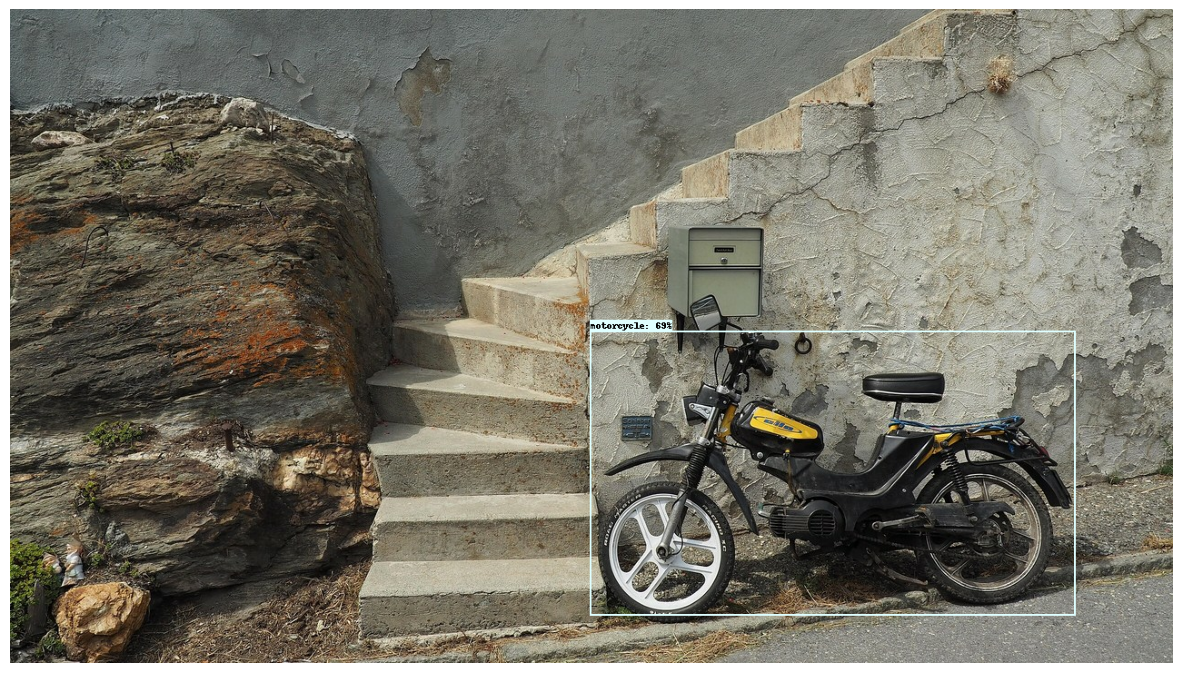

In [ ]:
filtered_result = filter_detected_output(result, threshold=0.45)
plot = draw_boxes_bylabel(((img*255).numpy()).astype(np.uint8),
                  filtered_result["detection_boxes"].numpy(),
                  filtered_result["detection_class_entities"].numpy(),
                  filtered_result["detection_scores"].numpy(),
                  filtered_result["detection_class_labels"].numpy()
                  min_score=0.1)
display_image(plot)

In [ ]:
filter_result = filter_detected_output(result)
plot = draw_boxes_bylabel(((img*255).numpy()).astype(np.uint8),
                  filter_result["detection_boxes"].numpy(),
                  filter_result["detection_class_entities"].numpy(),
                  filter_result["detection_scores"].numpy(),
                  filter_result["detection_class_labels"].numpy(),
                  labels = None, min_score=0.1)
display_image(plot)

In [ ]:
def inject_noise_to_result(result):
  # add some noise to model's result to test NMS algorithm
  result_injected = {"detection_boxes": [],
                    "detection_class_entities": [],
                    "detection_scores": [],
                    "detection_class_labels": []}
  for i in range(len(result["detection_boxes"])):
    bb = result["detection_boxes"][i].numpy()
    cls_name = result["detection_class_entities"][i].numpy()
    predict_score = result["detection_scores"][i].numpy()
    cls_id = result["detection_class_labels"][i].numpy()

    result_injected["detection_boxes"].append(bb)
    result_injected["detection_class_entities"].append(cls_name)
    result_injected["detection_scores"].append(predict_score)
    result_injected["detection_class_labels"].append(cls_id)

    num_inject = np.random.randint(4)

    ymin, xmin, ymax, xmax = bb
    w, h = xmax- xmin, ymax-ymin
    for _ in range(num_inject):
      # offset = np.random.randn(15) * 0.1 + 1
      # new_bb = bb*np.asarray([offset[0], offset[1], 1, 1])
      y_min = ymin + max(np.random.randn()*0.005, 0.005)
      x_min = xmin + max(np.random.randn()*0.005, 0.005)
      new_w, new_h = w + np.random.randn()*0, h + np.random.randn()*0 ,
      new_bb = np.asarray([max(0, y_min), max(0, x_min), min(y_min + new_h, 1), min(x_min+new_w, 1)])
      # print(bb, new_bb)
      new_score = min(100, predict_score* (1- abs(np.random.randn()*0.1)))
      # print(predict_score, new_score)
      result_injected["detection_boxes"].append(new_bb)
      result_injected["detection_class_entities"].append(cls_name)
      result_injected["detection_scores"].append(new_score)
      result_injected["detection_class_labels"].append(cls_id)
  result_injected["detection_boxes"] = np.asarray(result_injected["detection_boxes"])
  result_injected["detection_class_entities"] = np.asarray(result_injected["detection_class_entities"])
  result_injected["detection_scores"] = np.asarray(result_injected["detection_scores"])
  result_injected["detection_class_labels"] = np.asarray(result_injected["detection_class_labels"])
  return result_injected

In [ ]:
print("Total classes:", len(filter_result["detection_class_entities"]), filter_result["detection_class_entities"])

## Try with other images

In [ ]:
# TODO - Find other interesting images for detection

def download_and_detect(url: str, scale=0.5) -> None:
    path = download_and_rescale_image(url, scale)
    img = load_image(path)
    if model_name.startswith("yolo"):
        img_resized = tf.image.resize(img, size=(640, 640))
        result = detect_object(model, img_resized)
        result = parse_yolo_result(result)
    else:
        result = detect_object(model, img)

    plot = draw_boxes_bylabel(((img*255).numpy()).astype(np.uint8),
                  result["detection_boxes"].numpy(),
                  result["detection_class_entities"].numpy(),
                  result["detection_scores"].numpy(),
                  result["detection_class_labels"].numpy(),
                  labels = None, min_score=0.1)
    display_image(plot)

    filter_result = filter_detected_output(result, threshold=0.4)
    plot = draw_boxes_bylabel(((img*255).numpy()).astype(np.uint8),
                      filter_result["detection_boxes"].numpy(),
                      filter_result["detection_class_entities"].numpy(),
                      filter_result["detection_scores"].numpy(),
                      filter_result["detection_class_labels"].numpy(),
                      labels = None, min_score=0.1)
    display_image(plot)



<ipython-input-25-3b52e1230104>:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


Image downloaded to /tmp/tmp5omct3ig.jpg.
Total detected boxes: 78
Total detected boxes: 6


<ipython-input-25-3b52e1230104>:66: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-25-3b52e1230104>:76: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


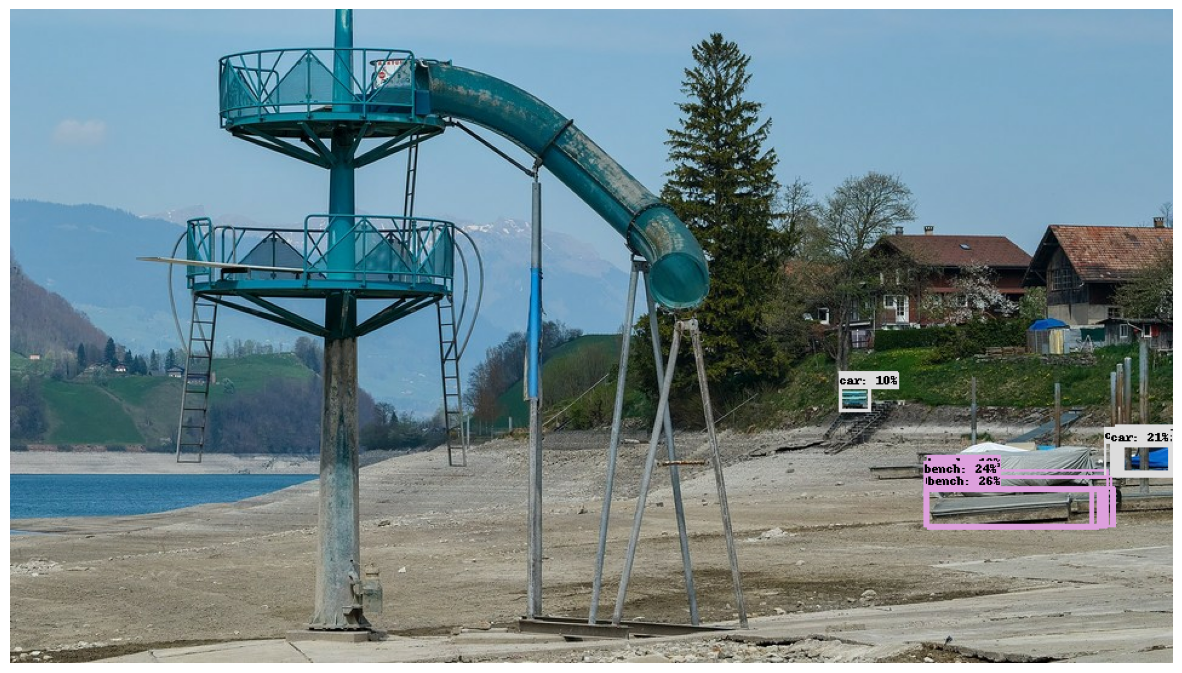

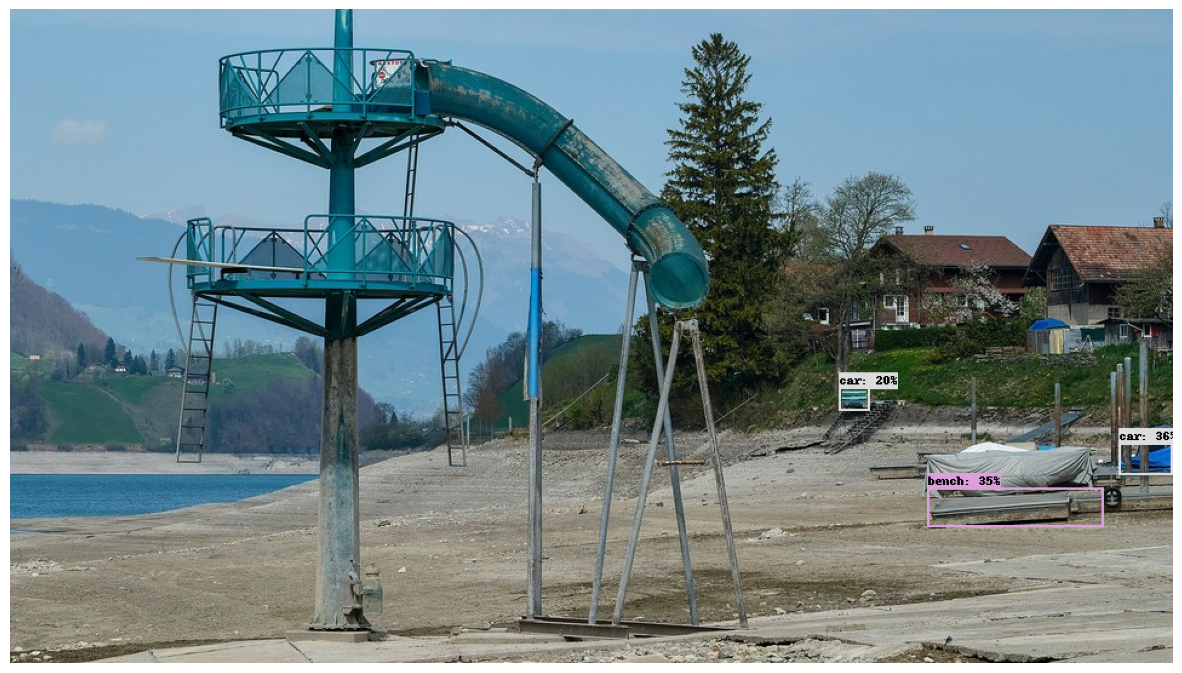

In [ ]:
download_and_detect("https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/CH.OW.Lungern_Lido_Water-Slide_4768_16x9-R_7K.jpg/1920px-CH.OW.Lungern_Lido_Water-Slide_4768_16x9-R_7K.jpg")

<ipython-input-25-3b52e1230104>:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


Image downloaded to /tmp/tmpfqxtgdir.jpg.
Total detected boxes: 365


<ipython-input-25-3b52e1230104>:66: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-25-3b52e1230104>:76: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


Total detected boxes: 17


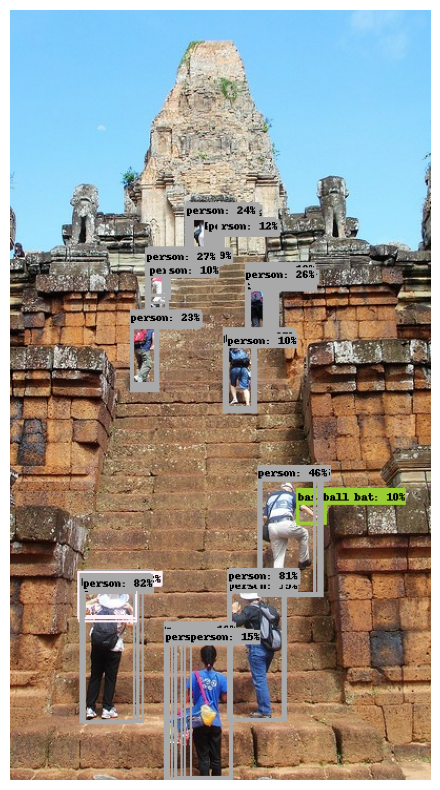

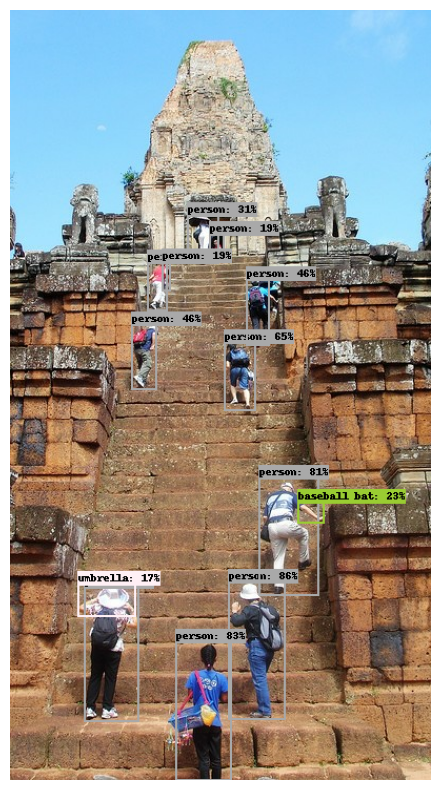

In [ ]:
download_and_detect("https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Climbing_up_on_stairs_at_Angkor_Wat.jpg/800px-Climbing_up_on_stairs_at_Angkor_Wat.jpg")

## Reference:

Object Detection  |  TensorFlow Hub. (2022). Retrieved 25 April 2022, from https://www.tensorflow.org/hub/tutorials/object_detection